In [2]:
def yaml_loader(filepath):
    with open(filepath, "r") as f:
        data = yaml.safe_load(f)
    return data

In [3]:
def join_tuple_string(strings_tuple) -> str:
    return '.'.join(strings_tuple)

def file_reader(sd: str, size):
    global result
    global df
    # get dimensions
    d = data.get('dimensions')
    options = list(d.values())

    # make list of tuples
    tuple = list(itertools.product(*options))

    # join tuples with '.'
    result = map(join_tuple_string, tuple)
    result = list(result)

    # read the file
    avg = []
    for i in result:
        # print(i)
        df = pd.read_csv(f'./log/{size}M/{sd}/{i}.txt', sep = ',', header = None)
        df = df.fillna(0)
        mean = df.mean(axis = 0)
        avg.append(mean)

    # create dataframe
    df = pd.DataFrame(avg, index = result)
    df = df.set_axis(["Q"+str(i+1) for i in range(data.get('query'))], axis = 1)
    df = df.fillna(5000)
    return df

In [4]:
# NON-DOMINATED SORTING ALGORITHM 
def nsga2(inputPoints, dominates):
    paretoPoints = set()
    candidateRowNr = 0
    dominatedPoints = set()
    while True:
        candidateRow = inputPoints[candidateRowNr] # masuk row pertama
        inputPoints.remove(candidateRow) # buang row pertamanya
        rowNr = 0
        nonDominated = True # row kandidat yg baru masuk di set true buat non dominated nya
        while len(inputPoints) != 0 and rowNr < len(inputPoints):
            row = inputPoints[rowNr] # ambil row lanjutannya
            if dominates(candidateRow, row): # ngecek row kandidat ama row lanjutan di input_point dominasinya
                # If it is worse on all features remove the row from the array
                inputPoints.remove(row)
                dominatedPoints.add(tuple(row))
            elif dominates(row, candidateRow):
                nonDominated = False
                dominatedPoints.add(tuple(candidateRow))
                rowNr += 1
            else:
                rowNr += 1

        if nonDominated:
            # add the non-dominated point to the Pareto frontier
            paretoPoints.add(tuple(candidateRow))

        if len(inputPoints) == 0:
            break
    return paretoPoints, dominatedPoints

def dominates(row, candidateRow):
    return np.sum([row[x] <= candidateRow[x] for x in range(len(row))]) == len(row)# kalo lebih kecil semua berarti dominasi
def dominates_agg(row, candidateRow):
    return np.sum([row[x] >= candidateRow[x] for x in range(len(row))]) == len(row)

def getDiagramPareto():
    fig = plt.figure()
    fig.set_size_inches(15, 15)
    ax = fig.add_subplot(111, projection='3d')
    dp = np.array(list(dominatedPoints))
    pp = np.array(list(paretoPoints))

    print(pp.shape,dp.shape)
    ax.scatter(dp[:,0],dp[:,1],dp[:,2])
    ax.scatter(pp[:,0],pp[:,1],pp[:,2],color='green')

    ax.set_xlabel('Rf')
    ax.set_ylabel('Rp')
    ax.set_zlabel('Rs')
    
    import matplotlib.tri as mtri
    triang = mtri.Triangulation(pp[:,0],pp[:,1])
    ax.plot_trisurf(triang,pp[:,2],color='green',alpha=0.3)
    plt.show()
    
# CREATE DICTIONARY WITH RANKS AS KEY AND INDEX AS VALUE
def getConfs(points,orignaldf):
  point_confs = {}
  for i in range(0, len(orignaldf)):
    for val in points:
      if (list(val)==np.array(orignaldf[i][1:], dtype=np.float64).tolist()):
        point_confs[val]=orignaldf[i][0]

  return point_confs

def getConfsSorted(confsDict):  
  # # summing all the values using sum()
  temp1 = {val: sum(float(idx) for idx in val) 
            for val, key in confsDict.items()} #sum the ranks of non dominated solution
  
    # using sorted to perform sorting as required
  temp2 = sorted(temp1.items(), key = lambda ele : temp1[ele[0]],reverse=False) #sort according to the sum before
  res={}
  for key, val in temp2:
    res[key]=confsDict[key]

  #print("The sorted dictionary : " + str(res))
  return res

def getParetoQ(size):
  global paretoPoints
  global dominatedPoints
  global pareto_q
    
  dimensionsAll = getRanking(size).reset_index().values
  dimensions = np.array(getRanking(size)[:], dtype = np.float64)
  inputPoints = dimensions.tolist()
  paretoPoints, dominatedPoints = nsga2(inputPoints, dominates)
  
  pareto_q = getConfs(paretoPoints, dimensionsAll)
  pareto_q = getConfsSorted(pareto_q)
  vals = np.array(list(pareto_q.values()))
  table_pareto = pd.DataFrame({'Solution': vals}, columns=['Solution'])
  
  dominated=  getConfs(dominatedPoints, dimensionsAll)
  dominated = getConfsSorted(dominated)
  vals = np.array(list(dominated.values()))
  table_dominated = pd.DataFrame({'Dominated': vals}, columns=['Dominated'])
  
  table = pd.concat([table_pareto, table_dominated], axis = 1)
  table = table.replace(np.nan, '', regex=True)
  return table


In [5]:
# R SCORE
def R_score(sd:str, size):
    global rank_dataframe
    global rank_dataframe_rscore
    file_reader(sd, size)
    
    # split dataframe
    dict = {}
    count = 0
    loop = len(list(data['dimensions'].values())[-1])
    dfs = []
    for i in range (int(len(result) / len(list(data['dimensions'].values())[-1]))):
        dict['df_{}'.format(i)] = df[count:loop]
        count = loop
        loop = loop+len(list(data['dimensions'].values())[-1])
        dfs.append(dict[f'df_{i}'])
        
    rank_dataframe = []
    for x in dfs:
        # CREATE RANK OCCURENCES
        df_ranks = x.T
        column_names = df_ranks.columns.to_numpy().tolist()
        
        df_ranks_occurences = []
        for index, row in df_ranks.iterrows():
            df_ranks_occurences.append(ss.rankdata(row, method = 'max'))

        df_ranks_occurences = pd.DataFrame(df_ranks_occurences)

        df_transpose = df_ranks_occurences.transpose()

        rank_table = []
        for index, row in df_transpose.iterrows():
            result_row = np.zeros(len(df_transpose.index))
            for i in range(len(row)):
                result_row[int(row[i])-1] +=1
            rank_table.append(result_row)

        rank_table = pd.DataFrame(rank_table)
        rank_table = rank_table.set_axis(column_names, axis = 'index')
        rank_table = rank_table.set_axis(['Rank '+str(i+1) for i in range(len(column_names))], axis='columns')
        
        # CREATE R SCORE
        q = data.get('query')
        d = len(rank_table.index)

        rank_score = []
        for index, row in rank_table.iterrows():
            s=0
            for r in range(d):  
                s = s + (row[r]*(d-(r+1)) / (q*(d-1)) )
            rank_score.append(s)
        rank_score = pd.DataFrame(rank_score)
        rank_score = rank_score.set_axis(column_names, axis = 'index')
        rank_score = rank_score.set_axis(['Result'], axis='columns')
        rank_score = pd.concat([rank_table, rank_score], axis = 1)
        rank_dataframe.append(rank_score)
    rank_dataframe_rscore = pd.concat(rank_dataframe)
    rank_dataframe_rscore.index = rank_dataframe_rscore.index.str.replace('.', ' ', regex=True)
    
    return rank_dataframe_rscore.sort_values(by=['Result'], ascending=False)

In [6]:
def rank_part(param1: list, param2: list):
    result = []
    for x in param1:
        for y in param2:
            test = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'(?=.*\b{x}\b)(?=.*\b{y}\b)', regex=True)]
            result.append(test)
    
    table = pd.concat(result)
    return table 

In [7]:
def getRanking(size):
    global df_full_ranks
    global df_transpose
    
    file_reader(sd = list(data['dimensions'].keys())[-1], size = size)
    df_transpose = df.T
    df_full_ranks = []
    for index, row in df_transpose.iterrows():
        df_full_ranks.append(ss.rankdata(row, method = 'max'))
    df_full_ranks = pd.DataFrame(df_full_ranks)
    df_full_ranks = df_full_ranks.T
    df_full_ranks = df_full_ranks.set_axis(df_transpose.columns, axis = 'index') #configurations  
    df_full_ranks = df_full_ranks.set_axis([i+1 for i in range(len(df_transpose.index))], axis='columns') #query
    
    return df_full_ranks

In [8]:
def getConformance(dataset, nValue: int, higherThan: int):
    value = []
    for x in dataset:
        # file_reader(x)
        # R_score(x)
        criteria_table = getRanking(x).loc[bestOfSD(x, nValue)] # single dimension
        
        getParetoQ(x)
        criteria_table_paretoQ = getRanking(x).loc[list(pareto_q.values())[:nValue]]
        
        criteria_table = criteria_table[criteria_table>higherThan]
        count = criteria_table.count(axis = 1)
        sum = count.sum(axis = 0)
        conformance = 1 - (sum/(nValue*11))
        value.append(conformance)
        
        criteria_table_paretoQ = criteria_table_paretoQ[criteria_table_paretoQ>higherThan]
        countParetoQ = criteria_table_paretoQ.count(axis = 1)
        sumParetoQ = countParetoQ.sum(axis = 0)
        conformanceParetoQ = 1 - (sumParetoQ/(nValue*11))
        value.append(conformanceParetoQ)
        
    value = np.array(value).reshape(2,2)
    table = pd.DataFrame(value, index = dataset, columns=['SD', 'ParetoQ'])
    return table

def bestOfSD(size,nValue):
    R_score(size)
    full_ranks_scores = pd.concat(rank_dataframe, axis = 0)
    full_ranks_scores = full_ranks_scores['Result']
    best_scores = full_ranks_scores.nlargest(nValue)
    return best_scores.index.to_numpy().tolist()

TESTING|

In [9]:
import yaml
import itertools
import pandas as pd
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure

filepath = 'settings.yaml'

data = yaml_loader(filepath)
# len(list(data['dimensions'].values())[-1])
# data.get('dimensions')

In [10]:
file_reader(sd = 'storage', size = 100)
R_score(sd = 'storage', size = 100)
getConformance()
# total = []
# for i in testing:
#     total.append(i.split("."))

# total[0][3]
# getParetoQ(100)

TypeError: R_score() missing 1 required positional argument: 'size'

In [35]:
parameter = 'st'
filter = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'\b{parameter}\b', regex = True)]
filter
# split = []
# dict = {}
# count = 0
# loop = len(list(data['dimensions'].values())[-1])
# for i in range (len(list(data['dimensions'].values())[-1])):
#     dict['df_{}'.format(i)] = filter[count:loop]['Result']
#     count = loop
#     loop = loop+len(list(data['dimensions'].values())[-1])
#     split.append(dict[f'df_{i}'])
# split

,Rank 1,Rank 2,Rank 3,Result
st horizontal csv,0.0,0.0,11.0,0.000000
st horizontal avro,1.0,10.0,0.0,0.545455
st horizontal parquet,10.0,1.0,0.0,0.954545
st predicate csv,0.0,1.0,10.0,0.045455
st predicate avro,7.0,4.0,0.0,0.818182
st predicate parquet,4.0,6.0,1.0,0.636364
st subject csv,0.0,0.0,11.0,0.000000
st subject avro,0.0,11.0,0.0,0.500000
st subject parquet,11.0,0.0,0.0,1.000000


In [373]:
s = 'st'
for key,value in data.get('dimensions').items():
    if s in value:
        print(key)

schemas


In [354]:
index = data.get('dimensions')['storage']
col = data.get('dimensions')['partition']


['horizontal', 'predicate', 'subject']

In [8]:
getParetoQ(100)

,Solution,Dominated
0,csv.vt.subject.option2,csv.vt.predicate.option1
1,csv.vt.horizontal.option2,csv.st.predicate.option1
2,csv.st.horizontal.option1,csv.st.horizontal.option2
3,csv.vt.horizontal.option1,csv.vt.subject.option1
4,csv.vt.predicate.option2,
5,csv.st.subject.option1,
6,csv.st.subject.option2,
7,csv.st.predicate.option2,


In [11]:
dataset = [100, 250]
getConformance(dataset, 3, 4)

TypeError: R_score() missing 1 required positional argument: 'size'

In [12]:
def file_reader(dimension: str, size: str):
    global df
    global dfs
    if dimension == "storage":
        idx = []
        li=[]
        # READ LOG - STORAGE FORMAT
        for i in schemas:
            for j in partition:
                for k in file_format:
                    # check folder
                    # print(f'./logs/{k}/{size}M_{i}_{j}.txt')

                    df = pd.read_csv(f'./logs/{k}/{size}M_{i}_{j}.txt',sep = ',', header = None)
                    df = df.fillna(0)
                    avg = df.mean(axis = 0)
                    li.append(avg)
                    idx.append(k + f"_{i}_{j}")

        # create dataframe
        df = pd.DataFrame(li, index = [idx])
        df = df.set_axis(["Q"+str(i+1) for i in range(11)], axis = 1)
        df = df.fillna(5000)
        # split dataframe
        dict = {}
        count = 0
        loop = len(file_format)
        dfs = []
        for i in range(int(len(partition) * len(file_format) * len(schemas) / len(file_format))):
            dict['df_{}'.format(i)] = df[count:loop]
            count = loop
            loop = loop+len(file_format)
            dfs.append(dict[f'df_{i}'])
##################################################################################################################################
    elif dimension == "partition":
        idx = []
        li=[]
        # READ LOG - STORAGE FORMAT
        for i in schemas:
            for k in file_format:
                for j in partition:
                    # check folder
                    # print(f'./logs/{k}/100M_{i}_{j}.txt')

                    df = pd.read_csv(f'./logs/{k}/{size}M_{i}_{j}.txt',sep = ',', header = None)
                    df = df.fillna(0)
                    avg = df.mean(axis = 0)
                    li.append(avg)
                    idx.append(k + f"_{i}_{j}")

        # create dataframe
        df = pd.DataFrame(li, index = [idx])
        df = df.set_axis(["Q"+str(i+1) for i in range(11)], axis = 1)
        df = df.fillna(5000)
        # split dataframe
        dict = {}
        count = 0
        loop = len(partition)
        dfs = []
        for i in range(int(len(partition) * len(file_format) * len(schemas) / len(partition))):
            dict['df_{}'.format(i)] = df[count:loop]
            count = loop
            loop = loop+len(partition)
            dfs.append(dict[f'df_{i}'])
############################################################################################################################################################
    elif dimension == "schema":
        idx = []
        li=[]
    # READ LOG - STORAGE FORMAT
        for j in partition:
            for k in file_format:
                for i in schemas:
                    # check folder
                    # print(f'./logs/{k}/100M_{i}_{j}.txt')

                    df = pd.read_csv(f'./logs/{k}/{size}M_{i}_{j}.txt',sep = ',', header = None)
                    df = df.fillna(0)
                    avg = df.mean(axis = 0)
                    li.append(avg)
                    idx.append(k + f"_{i}_{j}")

        # create dataframe
        df = pd.DataFrame(li, index = [idx])
        df = df.set_axis(["Q"+str(i+1) for i in range(11)], axis = 1)
        df = df.fillna(5000)
        # split dataframe
        dict = {}
        count = 0
        loop = len(schemas)
        dfs = []
        for i in range(int(len(partition) * len(file_format) * len(schemas) / len(schemas))):
            dict['df_{}'.format(i)] = df[count:loop]
            count = loop
            loop = loop+len(schemas)
            dfs.append(dict[f'df_{i}'])
    
    return df

In [13]:
import matplotlib.pyplot as plt

# NON-DOMINATED SORTING ALGORITHM 
def nsga2(inputPoints, dominates):
    paretoPoints = set()
    candidateRowNr = 0
    dominatedPoints = set()
    while True:
        candidateRow = inputPoints[candidateRowNr] # masuk row pertama
        inputPoints.remove(candidateRow) # buang row pertamanya
        rowNr = 0
        nonDominated = True # row kandidat yg baru masuk di set true buat non dominated nya
        while len(inputPoints) != 0 and rowNr < len(inputPoints):
            row = inputPoints[rowNr] # ambil row lanjutannya
            if dominates(candidateRow, row): # ngecek row kandidat ama row lanjutan di input_point dominasinya
                # If it is worse on all features remove the row from the array
                inputPoints.remove(row)
                dominatedPoints.add(tuple(row))
            elif dominates(row, candidateRow):
                nonDominated = False
                dominatedPoints.add(tuple(candidateRow))
                rowNr += 1
            else:
                rowNr += 1

        if nonDominated:
            # add the non-dominated point to the Pareto frontier
            paretoPoints.add(tuple(candidateRow))

        if len(inputPoints) == 0:
            break
    return paretoPoints, dominatedPoints

def dominates(row, candidateRow):
    return np.sum([row[x] <= candidateRow[x] for x in range(len(row))]) == len(row)# kalo lebih kecil semua berarti dominasi
def dominates_agg(row, candidateRow):
    return np.sum([row[x] >= candidateRow[x] for x in range(len(row))]) == len(row)

# DRAW PARETO DIAGRAM
def getDiagramPareto():
    fig = plt.figure()
    fig.set_size_inches(15, 15)
    ax = fig.add_subplot(111, projection='3d')
    dp = np.array(list(dominatedPoints))
    pp = np.array(list(paretoPoints))

    print(pp.shape,dp.shape)
    ax.scatter(dp[:,0],dp[:,1],dp[:,2])
    ax.scatter(pp[:,0],pp[:,1],pp[:,2],color='green')

    ax.set_xlabel('Rf')
    ax.set_ylabel('Rp')
    ax.set_zlabel('Rs')
    
    import matplotlib.tri as mtri
    triang = mtri.Triangulation(pp[:,0],pp[:,1])
    ax.plot_trisurf(triang,pp[:,2],color='green',alpha=0.3)
    plt.show()
    
# CREATE DICTIONARY WITH RANKS AS KEY AND INDEX AS VALUE
def getConfs(points,orignaldf):
  point_confs = {}
  for i in range(0, len(orignaldf)):
    for val in points:
      if (list(val)==np.array(orignaldf[i][1:], dtype=np.float64).tolist()):
        point_confs[val]=orignaldf[i][0]

  return point_confs

def getConfsSorted(confsDict):  
  # # summing all the values using sum()
  temp1 = {val: sum(float(idx) for idx in val) 
            for val, key in confsDict.items()} #sum the ranks of non dominated solution
        
  # using sorted to perform sorting as required
  temp2 = sorted(temp1.items(), key = lambda ele : temp1[ele[0]],reverse=False) #sort according to the sum before
  res={}
  for key, val in temp2:
    res[key]=confsDict[key]

  #print("The sorted dictionary : " + str(res))
  return res

def getPareto_Q(size):
    global paretoPoints
    global dominatedPoints
    global pareto_q
    
    file_reader(dimension,size)
    
    dimensionsAll = getRanking().reset_index().values
    dimensions = np.array(getRanking()[:], dtype = np.float64)
    inputPoints = dimensions.tolist()
    paretoPoints, dominatedPoints = nsga2(inputPoints, dominates)

    pareto_q = getConfs(paretoPoints, dimensionsAll)
    pareto_q = getConfsSorted(pareto_q)

    vals = np.array(list(pareto_q.values()))
    table_pareto = pd.DataFrame({'Solution': vals}, columns=['Solution'])

    dominated=  getConfs(dominatedPoints, dimensionsAll)
    dominated = getConfsSorted(dominated)
    vals = np.array(list(dominated.values()))
    table_dominated = pd.DataFrame({'Dominated': vals}, columns=['Dominated'])

    table = pd.concat([table_pareto, table_dominated], axis = 1)
    table = table.replace(np.nan, '', regex=True)
    return table

def getPareto_Agg(size):
    global paretoPoints
    global dominatedPoints
    global pareto_agg
    
    file_reader('schema',size)
    var1 = R_score(dimension, size)['Result']
    file_reader('storage',size)
    var2 = R_score(dimension, size)['Result'] 
    file_reader('partition',size)
    var3 = R_score(dimension, size)['Result']

    new_df = pd.concat([var1, var2, var3], axis = 1)
    new_df.index = new_df.index.str.replace(' ', '_')
    dimensionsAll = new_df.reset_index().values
    dimensions = np.array(dimensionsAll[:,1:], dtype = np.float64)

    inputPoints = dimensions.tolist()
    paretoPoints, dominatedPoints = nsga2(inputPoints, dominates_agg)

    pareto_agg = getConfs(paretoPoints, dimensionsAll)
    pareto_agg = getConfsSorted(pareto_agg)
    vals = np.array(list(pareto_agg.values()))
    table_pareto = pd.DataFrame(vals, columns=['Solution'])

    dominated = getConfs(dominatedPoints, dimensionsAll)
    dominated = getConfsSorted(dominated)
    vals = np.array(list(dominated.values()))
    table_dominated = pd.DataFrame({'Dominated': vals}, columns=['Dominated'])
    
    table = pd.concat([table_pareto, table_dominated], axis = 1)
    table = table.replace(np.nan, '', regex=True)
    return table

In [14]:
def R_score(dimension, size):
    # CREATE RANK OCCURENCES        
    global rank_dataframe
    global rank_dataframe_rscore
    
    file_reader(dimension,size)
    
    rank_dataframe = []

    for x in dfs:
        df_ranks = x.T
        column_names = df_ranks.columns.to_numpy().tolist()
        column_names = [column_names for column_names, in column_names]
        
        df_ranks_occurences = []
        for index, row in df_ranks.iterrows():
            df_ranks_occurences.append(ss.rankdata(row, method = 'max'))

        df_ranks_occurences = pd.DataFrame(df_ranks_occurences)

        df_transpose = df_ranks_occurences.transpose()

        rank_table = []
        for index, row in df_transpose.iterrows():
            result_row = np.zeros(len(df_transpose.index))
            for i in range(len(row)):
                result_row[int(row[i])-1] +=1
            rank_table.append(result_row)

        rank_table = pd.DataFrame(rank_table)
        rank_table = rank_table.set_axis(column_names, axis = 'index')
        rank_table = rank_table.set_axis([i+1 for i in range(len(column_names))], axis='columns')

        # CREATE R SCORE
        q = 11
        d = len(rank_table.index)

        rank_score = []
        for index, row in rank_table.iterrows():
            s = 0
            for r in range(d):  
                s = s + (row[r+1]*(d-(r+1)) / (q*(d-1)) )
            rank_score.append(s)
        rank_score = pd.DataFrame(rank_score)
        rank_score = rank_score.set_axis(column_names, axis = 'index')
        rank_score = rank_score.set_axis(['Result'], axis='columns')
        rank_score = pd.concat([rank_table, rank_score], axis = 1)
        rank_dataframe.append(rank_score)
    rank_dataframe_rscore = pd.concat(rank_dataframe)
    rank_dataframe_rscore.index = rank_dataframe_rscore.index.str.replace('_', ' ', regex=True)
    
    return rank_dataframe_rscore

In [15]:
def rank_part(param1, param2):
    result = []
    for x in param1:
        for y in param2:
            test = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'(?=.*\b{x}\b)(?=.*\b{y}\b)', regex=True)]
            result.append(test)
    
    table = pd.concat(result)
    return table            

In [16]:
import plotly.express as px
import pandas as pd

def radarDiagram(dimension, size):
    result = R_score(dimension, size)['Result'].idxmax().split()
    d = ['storage', 'schema', 'partition']
    x = result[0]
    y = result[1]
    z = result[2]
    
    data = []
    for i in d:
        R_score(i, size)
        r = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'(?=.*\b{x}\b)(?=.*\b{y}\b)(?=.*\b{z}\b)', regex=True)]['Result']
        data.append(r[0])
    
    print(result)
    print(data)
    
    df = pd.DataFrame(dict(
    r=data, theta=result))
    fig = px.line_polar(df, r='r', theta='theta', line_close=True)
    return fig.show()

In [17]:
def getDiagramSD(a):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib.pyplot import figure
    
    if dimension == "partition":
        if a not in partition:
            filter = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'\b{a}\b', regex = True)]
            
            if a in file_format:
                dict = {}
                loop = len(partition)
                count = 0
                for i in schemas:
                    dict['{}'.format(i)] = filter[count:loop]
                    count = loop
                    loop = loop+len(partition)

                key = list(dict)
                dict2 = {}
                # allVal = np.empty([0,4])
                for j in range(len(schemas)):
                    val = list(dict[key[j]]['Result'])
                    dict2['val{}'.format(j)] = val
                    
                data = np.vstack(list(dict2.values()))
                df2 = pd.DataFrame(data=data, index=list(dict.keys()), columns=partition)
                return df2.plot.bar(title = str(a) + " diagram", rot=0, fontsize = 14, figsize = (10,10))
                
            elif a in schemas:
                dict = {}
                loop = len(partition)
                count = 0
                for i in file_format:
                    dict['{}'.format(i)] = filter[count:loop]
                    count = loop
                    loop = loop+len(partition)

                key = list(dict)
                dict2 = {}
                # allVal = np.empty([0,4])
                for j in range(len(file_format)):
                    val = list(dict[key[j]]['Result'])
                    dict2['val{}'.format(j)] = val
                    
                data = np.vstack(list(dict2.values()))
                df2 = pd.DataFrame(data=data, index=list(dict.keys()), columns=partition)
                return df2.plot.bar(title = str(a) + " diagram", rot=0, fontsize = 14, figsize = (10,10))
                
                # for container in ax.containers:
                #     ax.bar_label(container)
        else:
            return 'the dimension is partition!'
    
    if dimension == "schema":
        if a not in schemas:
            filter = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'\b{a}\b', regex = True)]
            
            if a in file_format:
                dict = {}
                loop = len(schemas)
                count = 0
                for i in partition:
                    dict['{}'.format(i)] = filter[count:loop]
                    count = loop
                    loop = loop+len(schemas)

                key = list(dict)
                dict2 = {}
                # allVal = np.empty([0,4])
                for j in range(len(partition)):
                    val = list(dict[key[j]]['Result'])
                    dict2['val{}'.format(j)] = val
                    
                data = np.vstack(list(dict2.values()))
                df2 = pd.DataFrame(data=data, index=list(dict.keys()), columns=schemas)
                return df2.plot.bar(title = str(a) + " diagram", rot=0, fontsize = 14, figsize = (10,10))
                
            elif a in partition:
                dict = {}
                loop = len(schemas)
                count = 0
                for i in file_format:
                    dict['{}'.format(i)] = filter[count:loop]
                    count = loop
                    loop = loop+len(schemas)

                key = list(dict)
                dict2 = {}
                # allVal = np.empty([0,4])
                for j in range(len(file_format)):
                    val = list(dict[key[j]]['Result'])
                    dict2['val{}'.format(j)] = val
                    
                data = np.vstack(list(dict2.values()))
                df2 = pd.DataFrame(data=data, index=list(dict.keys()), columns=schemas)
                return df2.plot.bar(title = str(a) + " diagram", rot=0, fontsize = 14, figsize = (10,10))
        else:
            return 'the dimension is schema!'
    
    if dimension == "storage":
        if a not in file_format:
            filter = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'\b{a}\b', regex = True)]

            if a in schemas:
                dict = {}
                loop = len(file_format)
                count = 0
                for i in partition:
                    dict['{}'.format(i)] = filter[count:loop]
                    count = loop
                    loop = loop+len(file_format)

                key = list(dict)
                dict2 = {}
                # allVal = np.empty([0,4])
                for j in range(len(partition)):
                    val = list(dict[key[j]]['Result'])
                    dict2['val{}'.format(j)] = val
                    
                data = np.vstack(list(dict2.values()))
                df2 = pd.DataFrame(data=data, index=list(dict.keys()), columns=file_format)
                return df2.plot.bar(title = str(a) + " diagram", rot=0, fontsize = 14, figsize = (10,10))
                
            elif a in partition:
                dict = {}
                loop = len(file_format)
                count = 0
                for i in schemas:
                    dict['{}'.format(i)] = filter[count:loop]
                    count = loop
                    loop = loop+len(file_format)

                key = list(dict)
                dict2 = {}
                # allVal = np.empty([0,4])
                for j in range(len(schemas)):
                    val = list(dict[key[j]]['Result'])
                    dict2['val{}'.format(j)] = val
                    
                data = np.vstack(list(dict2.values()))
                df2 = pd.DataFrame(data=data, index=list(dict.keys()), columns=file_format)
                return df2.plot.bar(title = str(a) + " diagram", rot=0, fontsize = 14, figsize = (10,10))
        else:
            return 'the dimension is storage!'

In [18]:
def getConformance(dimension, dataset, nValue: int, higherThan: int):
    global df_transpose
    
    #CREATE CRITERIA TABLE
    data = []
    for x in dimension:
        for y in dataset:
            print(x,y)
            file_reader(x,y)
            R_score(dimension, size)
            criteria_table = getRanking().loc[bestOfSD(nValue)]
            if x == 'pareto_Q':
                file_reader('storage',y)
                getPareto_Q(y)
                criteria_table = getRanking().loc[list(pareto_q.values())[:nValue]]
            if x == 'pareto_Agg':
                getPareto_Agg(y)
                criteria_table = getRanking().loc[list(pareto_agg.values())[:nValue]]  
            
            # GET CONFIGURATION THAT IS HIGHER THAN 30% OF TOTAL CONFIGURATION
            criteria_table = criteria_table[criteria_table > higherThan]
            count = criteria_table.count(axis=1)
            avg = count.mean(axis = 0)
            # count, avg
            # GET CONFORMANCE
            sum = count.sum(axis = 0)
            conformance = 1 - (sum/(nValue*11)) #what is 55??
            data.append(conformance)
    data = np.array(data).reshape(len(dimension), len(dataset))
    table = pd.DataFrame(data, index=dimension, columns=dataset)
    return table

#GET BEST SCORES OF 5
def bestOfSD(nValue):
    full_ranks_scores = pd.concat(rank_dataframe, axis = 0)
    full_ranks_scores = full_ranks_scores['Result']
    best_scores = full_ranks_scores.nlargest(nValue)
    return best_scores.index.to_numpy().tolist()

# GET RANKS OF THE DATAFRAME
def getRanking():
    global df_full_ranks
    global df_transpose
    
    df_transpose = df.T
    df_full_ranks = []
    for index, row in df_transpose.iterrows():
        df_full_ranks.append(ss.rankdata(row, method = 'max'))
    df_full_ranks = pd.DataFrame(df_full_ranks)
    df_full_ranks = df_full_ranks.T
    df_full_ranks = df_full_ranks.set_axis(df_transpose.columns, axis = 'index') #configurations  
    df_full_ranks = df_full_ranks.set_axis([i+1 for i in range(len(df_transpose.index))], axis='columns') #query
    
    return df_full_ranks

In [19]:
def getCoherence(dimension, dataset1: int, dataset2: int):
    score = []
    distance = []
    for x in dimension:
        if x == 'pareto_Q':
            file_reader('storage', dataset1)
            R_score(dimension, size)
            getPareto_Q(dataset1)
            var1 = pd.concat(rank_dataframe, axis = 0)
            var1 = var1.loc[list(pareto_q.values())]
            var1 = var1['Result']
            
            file_reader('storage',dataset2)
            R_score(dimension, size)
            getPareto_Q(dataset2)
            var2 = pd.concat(rank_dataframe, axis = 0)
            var2 = var2.loc[list(pareto_q.values())]
            var2 = var2['Result']
            
            new_df = pd.concat([var1, var2], axis = 1)
            column_name = new_df.columns.values
            column_name[0] = str(dataset1) #var1
            column_name[1] = str(dataset2) #var2

            new_df.columns = column_name
            new_df = new_df.fillna(1)
            var1 = new_df[str(dataset1)]
            var2 = new_df[str(dataset2)]
        
        elif x == 'pareto_Agg':    
            getPareto_Agg(dataset1)
            var1 = pd.concat(rank_dataframe, axis = 0)
            var1 = var1.loc[list(pareto_agg.values())]
            var1 = var1['Result']
            
            getPareto_Agg(dataset2)
            var2 = pd.concat(rank_dataframe, axis = 0)
            var2 = var2.loc[list(pareto_agg.values())]
            var2 = var2['Result']
            
            new_df = pd.concat([var1, var2], axis = 1)
            column_name = new_df.columns.values
            column_name[0] = str(dataset1) #var1
            column_name[1] = str(dataset2) #var2

            new_df.columns = column_name
            new_df = new_df.fillna(1)
            var1 = new_df[str(dataset1)]
            var2 = new_df[str(dataset2)]
        else:
            file_reader(x, dataset1)
            R_score(dimension, size)
            var1 = pd.concat(rank_dataframe, axis = 0)
            var1 = var1['Result']
            
            file_reader(x,dataset2)
            R_score(dimension, size)
            var2 = pd.concat(rank_dataframe, axis = 0)
            var2 = var2['Result']

        # KENDALL'S SCORE
        result, pvalue = ss.kendalltau(var1,var2, nan_policy = 'omit', method = 'asymptotic', variant = 'b')
        score.append(result)
        # KENDALL'S DISTANCE
        var1_array = var1.to_numpy()
        var2_array = var2.to_numpy()
        res = normalised_kendall_tau_distance(var1_array, var2_array)
        distance.append(res)
        
    data = np.vstack((score, distance))
    return pd.DataFrame(data, columns = dimension, index=['score', 'distance'])

# kendall's distance
def normalised_kendall_tau_distance(values1, values2):
    """Compute the Kendall tau distance."""
    n = len(values1)
    assert len(values2) == n, "Both lists have to be of equal length"
    i, j = np.meshgrid(np.arange(n), np.arange(n))
    a = np.argsort(values1)
    b = np.argsort(values2)
    ndisordered = np.logical_or(np.logical_and(a[i] < a[j], b[i] > b[j]), np.logical_and(a[i] > a[j], b[i] < b[j])).sum()
    return ndisordered / (n * (n - 1))
    

<h3>This is a script to find the best performing configuration from a set of dimensions (partition, schema, storage)</h3>

Query runtimes of a single dimension set of configuration

In [22]:
# SINGLE DIMENSION #
import pandas as pd
import scipy.stats as ss
import numpy as np
file_format = ['csv', 'avro', 'parquet', 'orc']
schemas = ['st','vt', 'pt', 'extvt', 'wpt']
partition = ['horizontal','predicate', 'subject']
dimension = 'storage'
size = '250'

file_reader(dimension,size)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11
csv_st_horizontal,119.811581,434.534540,79.208559,833.553244,252.741987,299.149741,426.360434,537.442719,191.678927,53.058458,35.071883
avro_st_horizontal,61.605208,179.621290,31.063134,658.834816,95.885596,186.678078,288.816110,429.985433,119.866340,29.200286,12.852418
parquet_st_horizontal,39.440573,113.749201,14.500456,591.184875,75.671910,163.391413,245.607044,407.764548,91.364784,7.588160,3.869994
orc_st_horizontal,42.378732,110.825400,13.158544,656.996972,66.485270,203.631652,270.351702,407.240550,94.448321,6.983642,2.788286
csv_st_predicate,116.212925,408.827237,78.534839,823.262067,238.636782,309.673484,409.171700,548.116276,168.274577,82.144783,36.702343
avro_st_predicate,81.318466,164.169820,33.614049,710.471017,104.377956,274.194727,317.947424,485.456736,117.760664,46.507032,21.584215
parquet_st_predicate,54.538511,108.107410,28.664667,643.646836,89.637053,158.227649,268.950900,466.422044,112.448237,14.846991,4.670535
orc_st_predicate,41.796522,98.734800,21.105655,590.733618,72.615040,164.572155,203.416994,448.890928,96.341208,10.637278,2.523962
csv_st_subject,116.935944,422.748822,76.498997,796.847481,246.557554,271.979034,388.947217,527.328294,188.356603,54.592933,34.044350
avro_st_subject,57.643287,169.955491,27.962208,619.322019,89.408717,215.052230,347.350987,426.598422,119.673505,27.230969,12.104282


R Scores is a single dimensional ranking criteria which is used to help provide high-level view of the system performance across a set of tasks.<br> We apply the ranking criteria independently for each dimension

In [23]:
dimension = 'storage'
size = 250
R_score(dimension, size) #give formula in markdown

,1,2,3,4,Result
csv st horizontal,0.0,0.0,0.0,11.0,0.000000
avro st horizontal,0.0,1.0,10.0,0.0,0.363636
parquet st horizontal,5.0,6.0,0.0,0.0,0.818182
orc st horizontal,6.0,4.0,1.0,0.0,0.818182
csv st predicate,0.0,0.0,0.0,11.0,0.000000
avro st predicate,0.0,0.0,11.0,0.0,0.333333
parquet st predicate,1.0,10.0,0.0,0.0,0.696970
orc st predicate,10.0,1.0,0.0,0.0,0.969697
csv st subject,0.0,0.0,0.0,11.0,0.000000
avro st subject,0.0,0.0,11.0,0.0,0.333333


Here we can select 2 parameters that we want to see based on the full table of rank scores that we see before

In [ ]:
param1 = ['horizontal','predicate']
param2 = ['st', 'vt']
rank_part(param1, param2) #implement feature for query runtimes

This diagram shows the performance of a single dimension parameters that the user choose in terms of their rank scores

<AxesSubplot:title={'center':'st diagram'}>

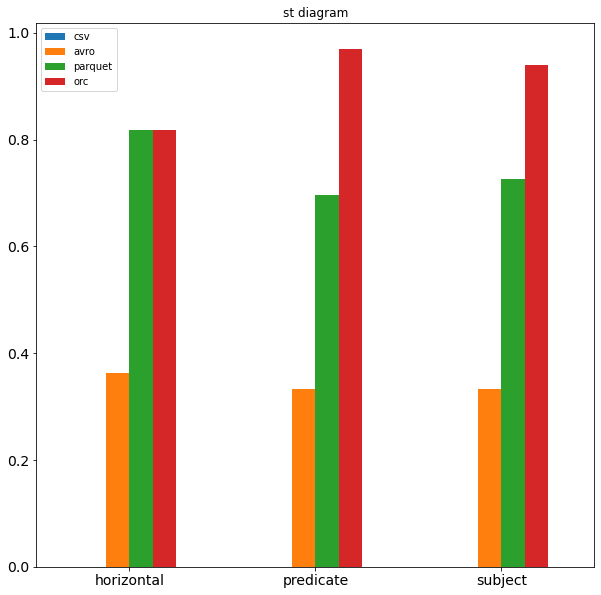

In [62]:
getDiagramSD('st')

However, ranking over one dimension ignoring the others ends up with selecting different configurations as we can see in the radar chart below

In [ ]:
dimension = 'storage'
size = 250
radarDiagram(dimension, size)

This is why we propose an optimization technique, aim to find the optimal non-dominated solutions or the configuration combinations by optimizing all dimensions at the same time which utilize the NSGA2 Algorithm. <br>
The <b>pareto_Q</b> apply the NSGA2 considering the rank sets obtained by sorting each query result individually. <br>
While the <b>pareto_Agg</b> operates on the single dimensional ranking criteria (schema, partition, storage) which aims to maximizing the performance of the three ranks all together

In [ ]:
# PARETO #
# getPareto_Q(250)
getPareto_Agg(250)

# Pareto's Diagram #
getDiagramPareto()

Conformance is a measure of the adherence of the top-ranked configurations according to the actual query positioning of those configurations

In [ ]:
# HEADLINE RANKING CRITERIA GOODNESS METRICS
# CONFORMANCE
dataset = [100,250]
dimension = ['storage', 'partition', 'schema', 'pareto_Q', 'pareto_Agg']
getConformance(dimension, dataset, 5, 13)

Coherence is the measure agreement between two ranking sets that use the same ranking criteria across different experiments

In [ ]:
# COHERENCE
dimension = ['storage', 'partition', 'schema', 'pareto_Q', 'pareto_Agg']
getCoherence(dimension, 100, 250)

CALCULATE COHERENCE

In [ ]:
getPareto_Agg(100)
var1 = pd.concat(rank_dataframe, axis = 0)
var1 = var1.loc[list(pareto_agg.values())]
var1 = var1['Result']

getPareto_Agg(250)
var2 = pd.concat(rank_dataframe, axis = 0)
var2 = var2.loc[list(pareto_agg.values())]
var2 = var2['Result']

new_df = pd.concat([var1, var2], axis = 1)
column_name = new_df.columns.values
column_name[0] = str(100) #var1
column_name[1] = str(250) #var2

# new_df.columns = column_name
# new_df = new_df.dropna()
# var1 = new_df[str(100)]
# var2 = new_df[str(250)]

In [ ]:
new_df

In [ ]:
file_format = ['csv', 'avro', 'parquet', 'orc']
schemas = ['st','vt', 'pt', 'extvt', 'wpt']
partition = ['horizontal','predicate', 'subject']
dimension = 'storage'
size = '250'

# for i in schemas:
#     for j in partition:
#         for k in file_format:
            # check folder
            # print(k,i,j)
            # print(f'./logs/{k}/{size}M_{i}_{j}.txt')
# dimension = 3

for i in range(dimension):
    for k in file_format:
        print(k)
            # df = pd.read_csv(f'./logs/{k}/{size}M_{i}_{j}.txt',sep = ',', header = None)

In [ ]:
storage = ['csv', 'avro', 'parquet', 'orc']
schemas = ['st','vt', 'pt', 'extvt', 'wpt']
partition = ['horizontal','predicate', 'subject']
# dimension = ['storage', 'schemas', 'partition']
size = '250'

# for i in schemas:
#     for k in file_format:
#         for j in partition:
#             print(i,k,j)
# def nested(dimension):
#     total_loop = len(storage)*len(schemas)*len(partition)
#     # return total_loop
#     for i in range(total_loop):
#         print(partition)

# nested(3)

In [ ]:
for i in range(len(dimension)):
    print(len(dimension[i]))

In [318]:
def nested(number_of_loops, range_list, execute_function, current_index=0, iter_list = []):
    if iter_list == []:
        iter_list = [0]*number_of_loops

    if current_index == number_of_loops-1:
        for iter_list[current_index] in range_list[current_index]:
            execute_function(iter_list)
    else:
        for iter_list[current_index] in range_list[current_index]:
            nested(number_of_loops, iter_list = iter_list, range_list = range_list,  current_index = current_index+1, execute_function = execute_function)

def read_log(index_list):
    # index_list[0]
    a = str(index_list)
    print(a)
    # b = index_list[1]
    # print(rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'(?=.*\b{index_list[0]}\b)(?=.*\b{index_list[1]}\b)', regex=True)])

In [319]:
nested(range_list = [['csv', 'avro'], ['st']], execute_function = read_log , number_of_loops=2)

['csv', 'st']
['avro', 'st']


In [279]:
param1 = ['csv', 'avro']
param2 = ['st']
for x in param1:
    for y in param2:
        print(x,y)

csv st
avro st


In [289]:
rank_dataframe_rscore

,Rank 1,Rank 2,Rank 3,Result
csv st horizontal,1.0,3.0,7.0,0.227273
csv st predicate,6.0,1.0,4.0,0.590909
csv st subject,4.0,7.0,0.0,0.681818
csv vt horizontal,1.0,6.0,4.0,0.363636
csv vt predicate,4.0,2.0,5.0,0.454545
csv vt subject,6.0,3.0,2.0,0.681818
csv pt horizontal,1.0,7.0,3.0,0.409091
csv pt predicate,0.0,1.0,10.0,0.045455
csv pt subject,8.0,1.0,2.0,0.772727
avro st horizontal,2.0,6.0,3.0,0.454545


In [ ]:
if current_index == number_of_loops-1:
        for iter_list[current_index] in range_list[current_index]:
            execute_function(iter_list)

In [ ]:
import itertools

a = list(itertools.product(*dimension))
print(len(a))

def file_reader2(dimensions, size: str):
    global df
    global dfs
    configurations = list(itertools.product(*dimensions))
    for c in configurations:
        
    if dimension == "storage":
        idx = []
        li=[]
        # READ LOG - STORAGE FORMAT
        for i in schemas:
            for j in partition:
                for k in file_format:
                    # check folder
                    # print(f'./logs/{k}/{size}M_{i}_{j}.txt')

                    df = pd.read_csv(f'./logs/{k}/{size}M_{i}_{j}.txt',sep = ',', header = None)
                    df = df.fillna(0)
                    avg = df.mean(axis = 0)
                    li.append(avg)
                    idx.append(k + f"_{i}_{j}")

        # create dataframe
        df = pd.DataFrame(li, index = [idx])
        df = df.set_axis(["Q"+str(i+1) for i in range(11)], axis = 1)
        df = df.fillna(5000)
        # split dataframe
        dict = {}
        count = 0
        loop = len(file_format)
        dfs = []
        for i in range(int(len(partition) * len(file_format) * len(schemas) / len(file_format))):
            dict['df_{}'.format(i)] = df[count:loop]
            count = loop
            loop = loop+len(file_format)
            dfs.append(dict[f'df_{i}'])

In [ ]:
import plotly.express as px
import pandas as pd
df = pd.DataFrame(dict(
    r=[0.98, 0.55, 0.23],
    theta=['ORC','ST','Predicate']))
fig = px.line_polar(df, r='r', theta='theta', line_close=True)
fig.show()

In [ ]:
s = R_score('storage', 250)['Result'].idxmax().split()
s

In [ ]:
x = 'st'
y = 'predicate'
z = 'orc'
r = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'(?=.*\b{x}\b)(?=.*\b{y}\b)(?=.*\b{z}\b)', regex=True)]['Result']
r[0]

In [ ]:
d = ['er', 'eraq', 'ewr']
for i in d:
    print(i)

In [ ]:
- dimensions:
    - schemas:
        wpt
        vt
    - partition:
        horizontal
    -storage:
        avro

In [ ]:
[(i,j) for i in range(10) for j in range(10,20)]